In [43]:
import os
import pickle
import pandas as pd
import scanpy as sc
import anndata as ad
import pycisTopic
import matplotlib.pyplot as plt

In [5]:
from pycisTopic.cistopic_class import create_cistopic_object

In [8]:
path_blacklist = "/cellar/users/aklie/data/ref/genomes/hg38/blacklist/ENCFF356LFX.bed.gz"

In [2]:
from pycisTopic.lda_models import run_cgs_models

In [42]:
atac = sc.read_h5ad("/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/atac.h5ad")

In [44]:
annotation = pd.read_csv("/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/annotations.tsv", index_col=0, header=None, sep="\t")
annotation.columns = ["cell_line"]
annotation

,cell_line
0,
ACTTTCTAATCA,BJ
GAGAGAAAACCT,K562
TACGGCTGTTAT,K562
GACGCGTAAGTG,BJ
GAAAGGACTGCA,BJ
...,...
GTTCTTCCTAGT,H1
ATCCGTTCAACG,H1
CCGACTAAGAAT,K562


In [11]:
cistopic_obj = create_cistopic_object(
    fragment_matrix=atac.X.T,
    cell_names=atac.obs_names,
    region_names=atac.var_names,
    path_to_blacklist=path_blacklist,
    project="cell_line_mixture",
)

2024-05-19 10:58:50,660 cisTopic     INFO     Removing blacklisted regions
2024-05-19 10:58:59,622 cisTopic     INFO     Creating CistopicObject
2024-05-19 10:59:10,606 cisTopic     INFO     Done!


In [14]:
# Run models
models = run_cgs_models(
    cistopic_obj,
    n_topics=[2, 5, 10, 15, 20, 25],
    n_cpu=3,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    _temp_dir="/cellar/users/aklie/tmp",
    save_path="/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/pycistopic",
)

2024-05-19 11:01:23,019	INFO worker.py:1724 -- Started a local Ray instance.


(run_cgs_model pid=3465112) 2024-05-19 11:01:27,598 cisTopic     INFO     Running model with 5 topics
(run_cgs_model pid=3465114) 2024-05-19 11:03:13,285 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=3465114) 2024-05-19 11:03:13,285 cisTopic     INFO     Saving model with 2 topics at /cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/pycistopic
(run_cgs_model pid=3465113) 2024-05-19 11:01:27,850 cisTopic     INFO     Running model with 10 topics [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(run_cgs_model pid=3465112) 2024-05-19 11:04:07,317 cisTopic     INFO     Model with 5 topics done!
(run_cgs_model pid=3465112) 2024-05-19 11:04:07,318 cisTopic     INFO     Saving model with 5 topics at /cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/a

In [17]:
pickle.dump(
    cistopic_obj,
    open(os.path.join("/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/pycistopic/cistopic_obj.pkl"), "wb")
)

In [22]:
cistopic_obj.cell_data.to_csv("/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/pycistopic/cell_data.csv")

In [31]:
from pycisTopic.clust_vis import run_umap
from pycisTopic.lda_models import evaluate_models

# Analysis

In [45]:
# Grab cell data
cell_data = cistopic_obj.cell_data.copy()
cell_data.index = cell_data.index.str.split("_", expand=True).get_level_values(0)
cell_data = cell_data.filter(like="cisTopic")
cell_data.head()

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc
ACTTTCTAATCA,1128,3.052309,1091,3.037825
GAGAGAAAACCT,1682,3.225826,1600,3.20412
TACGGCTGTTAT,217,2.33646,215,2.332438
GACGCGTAAGTG,1647,3.216694,1581,3.198932
GAAAGGACTGCA,813,2.910091,776,2.889862


In [46]:
# Join
atac.obs = atac.obs.join(cell_data)
atac.obs

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc
ACTTTCTAATCA,1128,3.052309,1091,3.037825
GAGAGAAAACCT,1682,3.225826,1600,3.20412
TACGGCTGTTAT,217,2.33646,215,2.332438
GACGCGTAAGTG,1647,3.216694,1581,3.198932
GAAAGGACTGCA,813,2.910091,776,2.889862
...,...,...,...,...
GTTCTTCCTAGT,866,2.937518,844,2.926342
ATCCGTTCAACG,306,2.485721,297,2.472756
CCGACTAAGAAT,615,2.788875,599,2.777427
AAGCCTGGGGGC,264,2.421604,259,2.4133


In [47]:
atac.obs["cell_line"] = annotation.index.map(annotation["cell_line"])

In [49]:
atac.obs["cell_line"].value_counts()

H1         388
BJ         322
K562       201
GM12878    136
Name: cell_line, dtype: int64

In [35]:
for n_topic in [2, 5, 10, 15, 20, 25]:
    print(f"Running {n_topic} topics")

    # Grab the model
    model = evaluate_models(
        models,
        select_model=n_topic,
        return_model=True,
        metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
        plot_metrics=False,
        plot=False
    )
    cistopic_obj.add_LDA_model(model)

    # Add the cell topic matrix to atac
    cell_topic_df = cistopic_obj.selected_model.cell_topic.copy()
    cell_topic_df.columns = cell_topic_df.columns.str.split("_", expand=True).get_level_values(0)
    cell_topic_df = cell_topic_df[atac.obs_names]
    atac.obsm[f"X_cisTopic_{n_topic}_topics"] = cell_topic_df.values.T
    
    # Run cisTopic UMAP and add to atac
    print("Running cisTopic UMAP")
    run_umap(cistopic_obj, target  = 'cell', scale=False)
    umap_dims = cistopic_obj.projections["cell"]["UMAP"].copy()
    umap_dims.index = umap_dims.index.str.split("_", expand=True).get_level_values(0)
    atac.obsm[f"X_cisTopic_umap_{n_topic}_topics"] = umap_dims.loc[atac.obs.index].values
    
    # Run scanpy UMAP and add to atac
    print("Running scanpy UMAP")
    sc.pp.neighbors(atac, use_rep=f"X_cisTopic_{n_topic}_topics", n_neighbors=30, metric="cosine")
    sc.tl.umap(atac, min_dist=0.1, spread=5, random_state=1234)
    atac.obsm[f"X_scanpy_umap_{n_topic}_topics"] = atac.obsm["X_umap"].copy()

    # Make an anndata where features are the topics
    atac_topics = ad.AnnData(
        X=cell_topic_df.values.copy().T,
        obs=atac.obs.copy(),
        var=pd.DataFrame(index=cell_topic_df.index)
    )

Running 2 topics
Running cisTopic UMAP
2024-05-19 13:55:53,944 cisTopic     INFO     Running UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Running scanpy UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Running 5 topics
Running cisTopic UMAP
2024-05-19 13:56:05,910 cisTopic     INFO     Running UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Running scanpy UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Running 10 topics
Running cisTopic UMAP
2024-05-19 13:56:18,996 cisTopic     INFO     Running UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Running scanpy UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Running 15 topics
Running cisTopic UMAP
2024-05-19 13:56:30,476 cisTopic     INFO     Running UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Running scanpy UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Running 20 topics
Running cisTopic UMAP
2024-05-19 13:56:42,527 cisTopic     INFO     Running UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Running scanpy UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Running 25 topics
Running cisTopic UMAP
2024-05-19 13:56:53,645 cisTopic     INFO     Running UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Running scanpy UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Plotting 2 topics
Plotting 5 topics
Plotting 10 topics
Plotting 15 topics
Plotting 20 topics
Plotting 25 topics


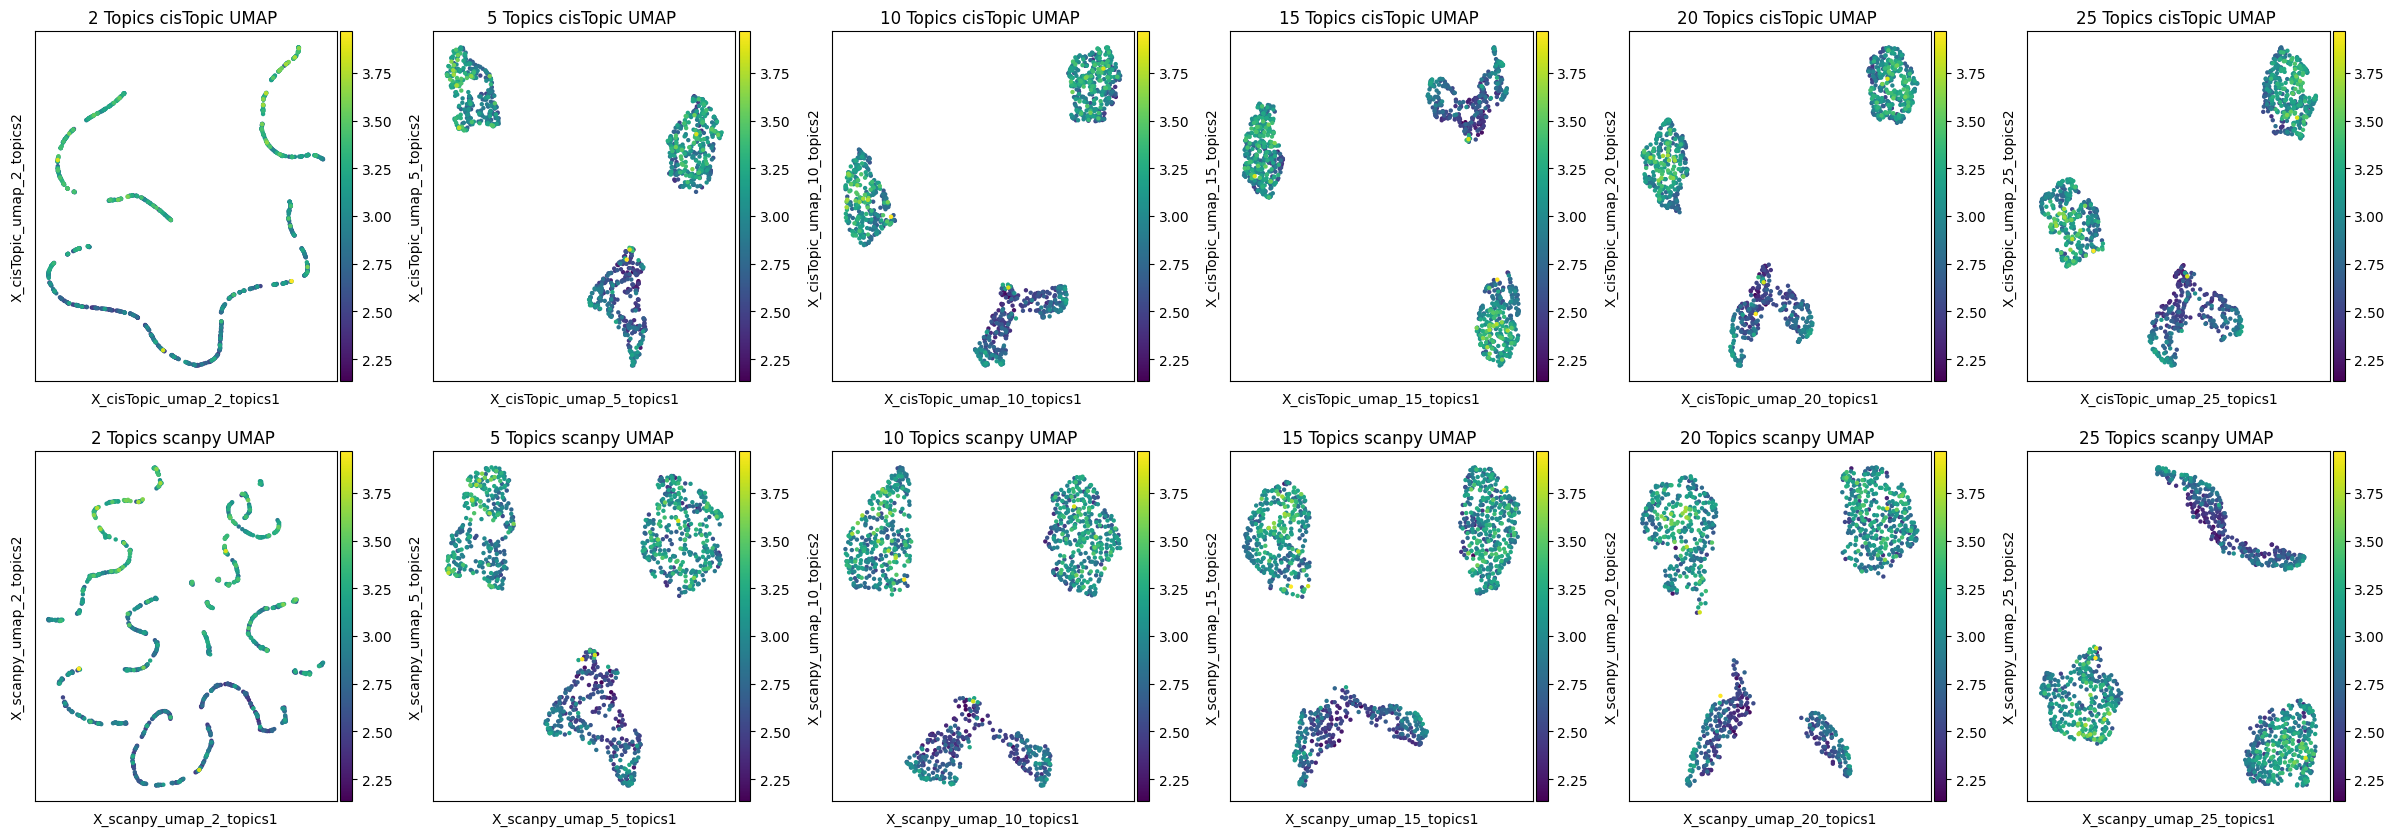

In [40]:
fig, ax = plt.subplots(2, 6, figsize=(30, 10))
metadata = "cisTopic_log_nr_frag"
for i, n_topic in enumerate([2, 5, 10, 15, 20, 25]):
    print(f"Plotting {n_topic} topics")
    sc.pl.embedding(atac, basis=f"X_cisTopic_umap_{n_topic}_topics", color=[metadata], s=40, wspace=0.2, ncols=2, show=False, ax=ax[0][i])
    ax[0][i].set_title(f"{n_topic} Topics cisTopic UMAP ")
    sc.pl.embedding(atac, basis=f"X_scanpy_umap_{n_topic}_topics", color=[metadata], s=40, wspace=0.2, ncols=2, show=False, ax=ax[1][i])
    ax[1][i].set_title(f"{n_topic} Topics scanpy UMAP ")

# Choose one model

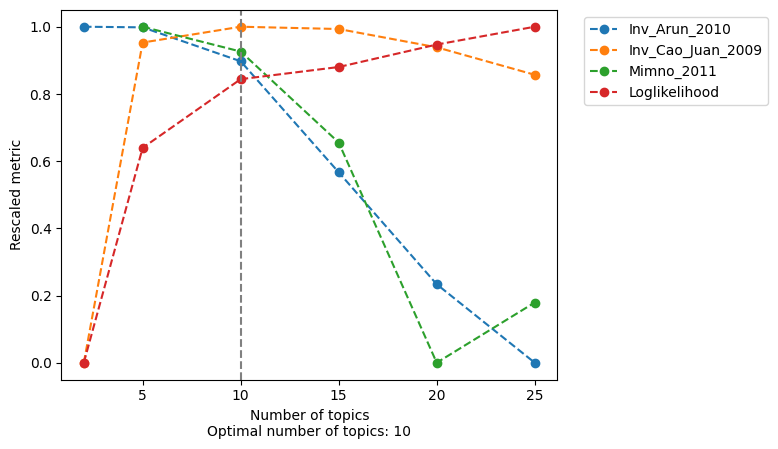

In [82]:
# Grab the model
model = evaluate_models(
    models,
    select_model=10,
    return_model=True,
    metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
    plot_metrics=False,
)
cistopic_obj.add_LDA_model(model)

In [83]:
# Add the cell topic matrix to atac
cell_topic_df = cistopic_obj.selected_model.cell_topic.copy()
cell_topic_df.columns = cell_topic_df.columns.str.split("_", expand=True).get_level_values(0)
cell_topic_df = cell_topic_df[atac.obs_names]
cell_topic_df.head()

,ACTTTCTAATCA,GAGAGAAAACCT,TACGGCTGTTAT,GACGCGTAAGTG,GAAAGGACTGCA,TGACCTGGATAA,ACTCCGTTCACT,TAGGTAGCGCGC,CTCTACCCTTCA,GCCCGTTATCTG,...,GGCCGCCCGGGG,TTCCCCTACAAC,TGTAATCATCTG,ACATAAATTAGT,ATAGTGCTCGCC,GTTCTTCCTAGT,ATCCGTTCAACG,CCGACTAAGAAT,AAGCCTGGGGGC,CAGCTGGTGATG
Topic1,0.029798,0.223030,0.083019,0.021459,0.029056,0.043888,0.036965,0.020246,0.017946,0.005710,...,0.136707,0.135135,0.056285,0.011936,0.010363,0.147651,0.167147,0.044684,0.190939,0.106561
Topic2,0.053462,0.090303,0.030189,0.010423,0.037530,0.072135,0.029183,0.020246,0.029084,0.030692,...,0.171450,0.144788,0.165103,0.029841,0.033161,0.142058,0.167147,0.060092,0.148867,0.161005
Topic3,0.030675,0.036970,0.109434,0.060699,0.020581,0.067986,0.020428,0.065141,0.015470,0.029979,...,0.031722,0.044402,0.039400,0.027188,0.046632,0.032438,0.066282,0.038521,0.051780,0.035365
Topic4,0.073620,0.027879,0.105660,0.047823,0.050847,0.044526,0.040856,0.031690,0.017946,0.060671,...,0.016616,0.106178,0.045028,0.028515,0.048705,0.040268,0.046110,0.251156,0.064725,0.066543
Topic5,0.028922,0.166061,0.026415,0.017167,0.015738,0.080115,0.017510,0.014965,0.022277,0.014989,...,0.154079,0.117761,0.157598,0.037798,0.019689,0.128635,0.161383,0.080123,0.129450,0.125174


In [84]:
# Make an anndata where features are the topics
adata_topics = ad.AnnData(
    X=cell_topic_df.values.copy().T,
    obs=atac.obs.copy(),
    var=pd.DataFrame(index=cell_topic_df.index)
)
adata_topics.obsm["X_cisTopic"] = cell_topic_df.values.T

In [85]:
# Run cisTopic UMAP
run_umap(cistopic_obj, target='cell', scale=False)

2024-05-19 14:37:32,980 cisTopic     INFO     Running UMAP


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [86]:
# Add to adata
umap_dims = cistopic_obj.projections["cell"]["UMAP"].copy()
umap_dims.index = umap_dims.index.str.split("_", expand=True).get_level_values(0)
adata_topics.obsm[f"X_umap"] = umap_dims.loc[adata_topics.obs.index].values

In [87]:
# Run scanpy UMAP and add to adata_topics
print("Running scanpy UMAP")
sc.pp.neighbors(adata_topics, use_rep=f"X_cisTopic", n_neighbors=30, metric="cosine")
sc.tl.umap(adata_topics, min_dist=0.3, spread=1, random_state=1234)
adata_topics.obsm[f"X_umap"] = adata_topics.obsm["X_umap"].copy()

Running scanpy UMAP


... storing 'cell_line' as categorical


/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


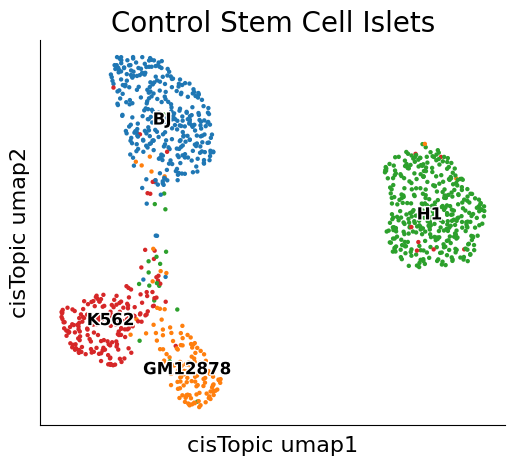

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
sc.pl.umap(
    adata_topics, 
    color=["cell_line"], 
    s=40, 
    show=False, 
    frameon=False, 
    legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    ax=ax
)
ax.axis("on")
ax.tick_params(
    top="off",
    bottom="on",
    left="on",
    right="off",
    labelleft="on",
    labelbottom="off",
)
_ = ax.set_xlabel("cisTopic umap1", fontsize=16)
_ = ax.set_ylabel("cisTopic umap2", fontsize=16)
_ = ax.set_title("Control Stem Cell Islets", fontsize=20)

#ax.set(frame_on=False)
# Set bottom and left spines to on
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


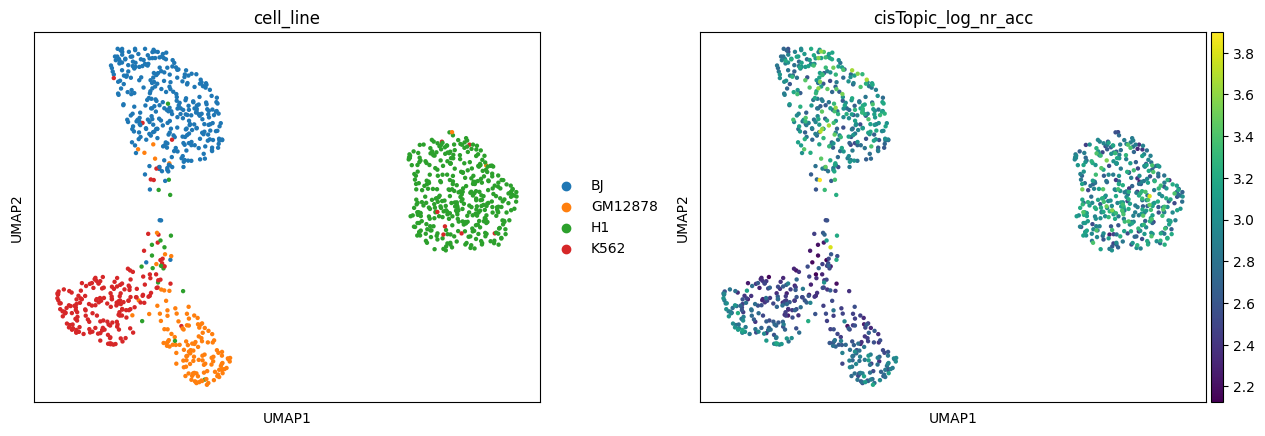

In [89]:
# Plot UMAP
sc.pl.umap(adata_topics, color=["cell_line", "cisTopic_log_nr_acc"], s=40, wspace=0.2, ncols=3)

In [90]:
# Add scaled data layer
adata_topics.layers["scaled"] = sc.pp.scale(adata_topics, copy=True).X

/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


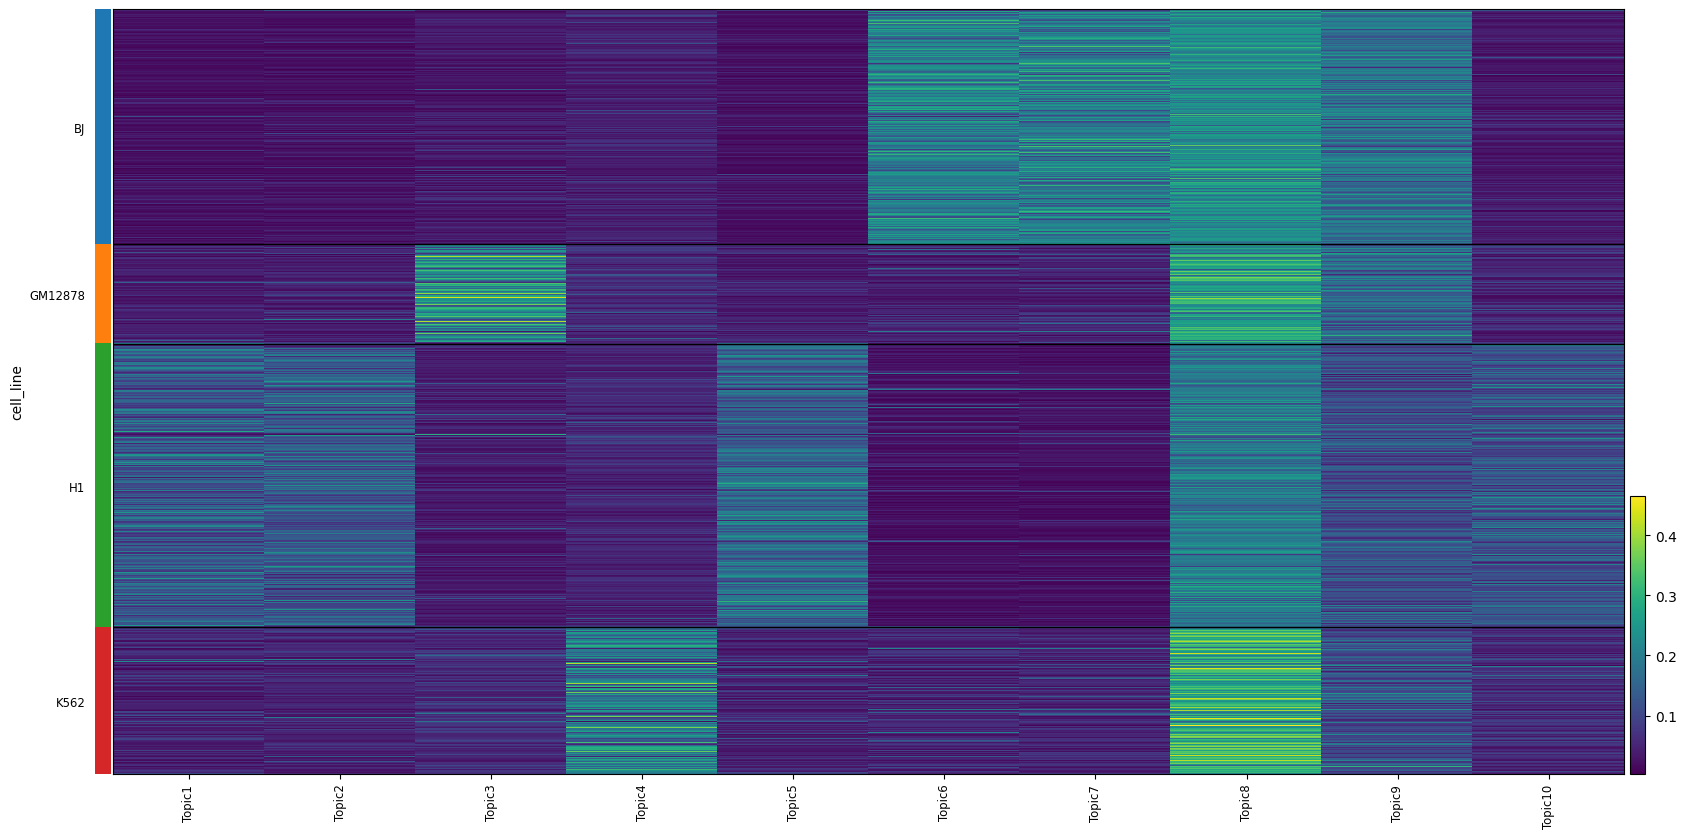

In [91]:
# Plot as heatmap
ax = sc.pl.heatmap(
    adata_topics,
    var_names=adata_topics.var_names,
    groupby="cell_line",
    use_raw=False,
    log=False,
    figsize=(20, 10),
    cmap="viridis",
    #layer="scaled",
    show=False,
    show_gene_labels=True,
    #vmin=-2,
    #vmax=4,
)

In [92]:
sc.tl.rank_genes_groups(adata_topics, groupby="cell_line", method="wilcoxon", n_genes=10)

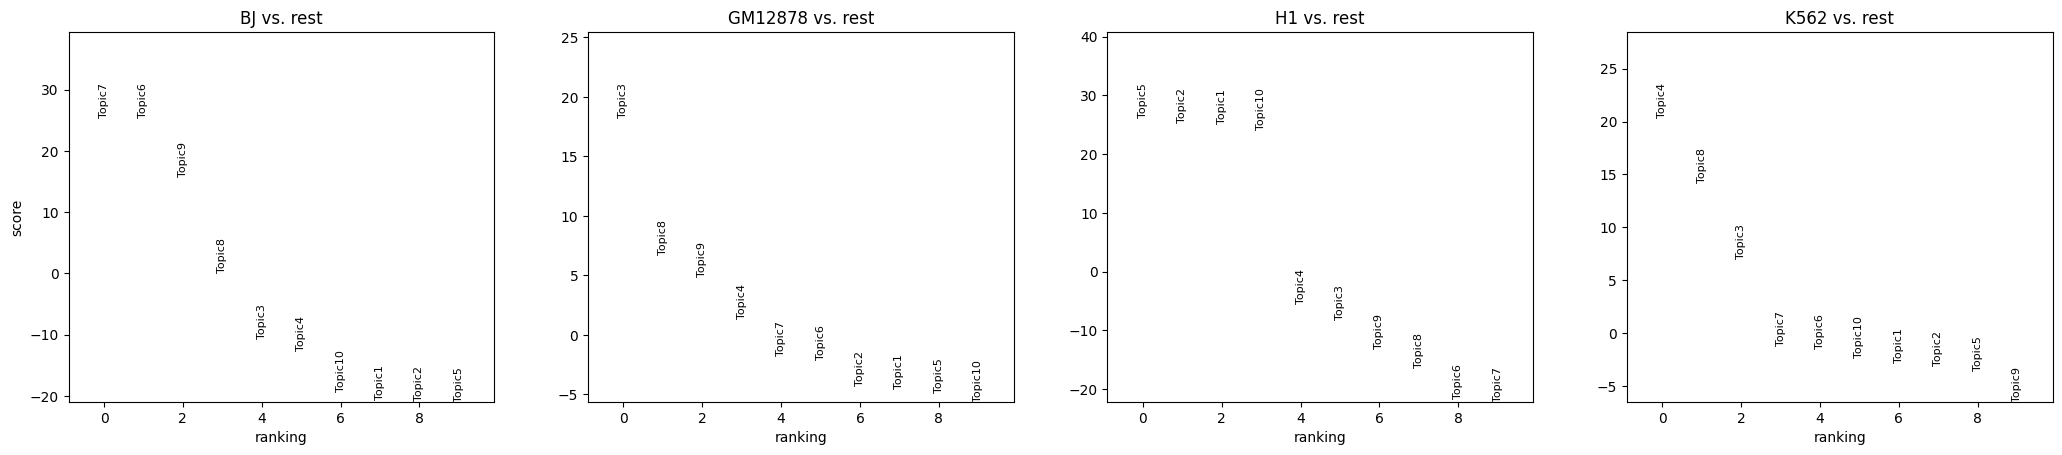

In [93]:
sc.pl.rank_genes_groups(adata_topics, n_genes=10, sharey=False)

/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus_dev/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


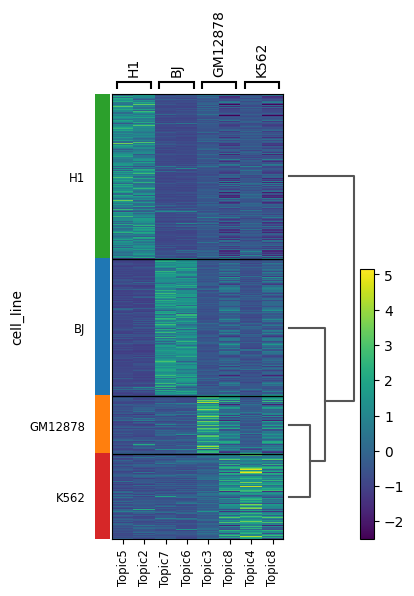

In [95]:
sc.pl.rank_genes_groups_heatmap(adata_topics, groupby="cell_line", n_genes=2, use_raw=False, log=False, show_gene_labels=True, layer="scaled", cmap="viridis")

In [97]:
# Get dictionary of top 2 marker genes for each annotation
marker_topics = {}
for annotation in adata_topics.obs["cell_line"].unique():
    marker_genes = adata_topics.uns["rank_genes_groups"]["names"][annotation]
    marker_topics[annotation] = marker_genes[:3]
marker_topics

order = ["BJ", "H1", "GM12878", "K562"]
marker_topics = {k: v for k, v in marker_topics.items() if k in order}

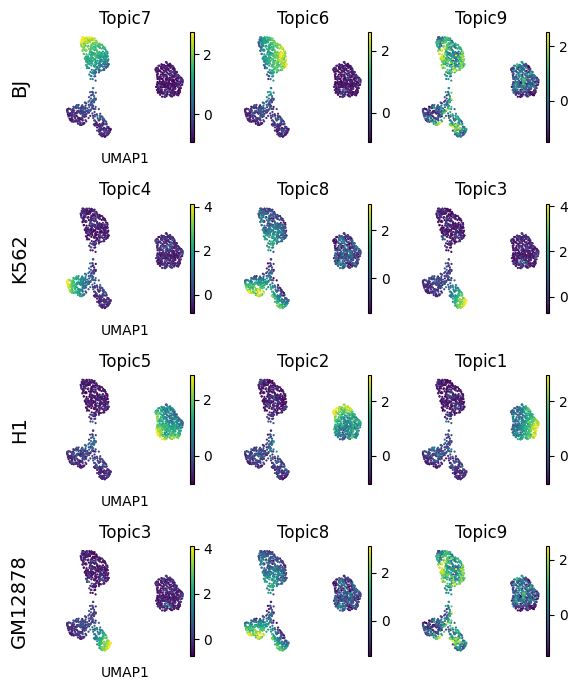

In [98]:
nrow = len(marker_topics)
ncol = max([len(vs) for vs in marker_topics.values()])
fig, axs = plt.subplots(nrow, ncol, figsize=(2 * ncol, 1.75 * nrow))
for row_idx, (annotation, markers) in enumerate(marker_topics.items()):
    col_idx = 0
    for marker in markers:
        ax = axs[row_idx, col_idx]
        sc.pl.umap(adata_topics, color=marker, ax=ax, show=False, frameon=False, s=10, vmin="p5", vmax="p99.5", layer="scaled")
        if col_idx == 0:
            # We disabled axis drawing in UMAP to have plots without background and border
            # so we need to re-enable axis to plot the ylabel
            ax.axis("on")
            ax.tick_params(
                top="off",
                bottom="off",
                left="off",
                right="off",
                labelleft="on",
                labelbottom="off",
            )
            ax.set_ylabel(annotation + "\n", rotation=90, fontsize=14)
            ax.set(frame_on=False)
        col_idx += 1
    # Remove unused column Axes in the current row
    while col_idx < ncol:
        axs[row_idx, col_idx].remove()
        col_idx += 1
        
# Alignment within the Figure
fig.tight_layout()

In [ ]:
sc.pp.neighbors(adata_topics, use_rep="X_cisTopic", n_neighbors=30, metric="cosine")

In [ ]:
sc.tl.leiden(adata_topics, resolution=0.2, key_added="leiden_0.2_32_topics")
sc.tl.leiden(adata_topics, resolution=0.5, key_added="leiden_0.5_32_topics")
sc.tl.leiden(adata_topics, resolution=0.8, key_added="leiden_0.8_32_topics")
sc.tl.leiden(adata_topics, resolution=1.0, key_added="leiden_1.0_32_topics")
sc.tl.leiden(adata_topics, resolution=1.5, key_added="leiden_1.5_32_topics")

/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus/

[<AxesSubplot: title={'center': 'leiden_0.2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'leiden_0.5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'leiden_0.8'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'leiden_1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'leiden_1.5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot: title={'center': 'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>]

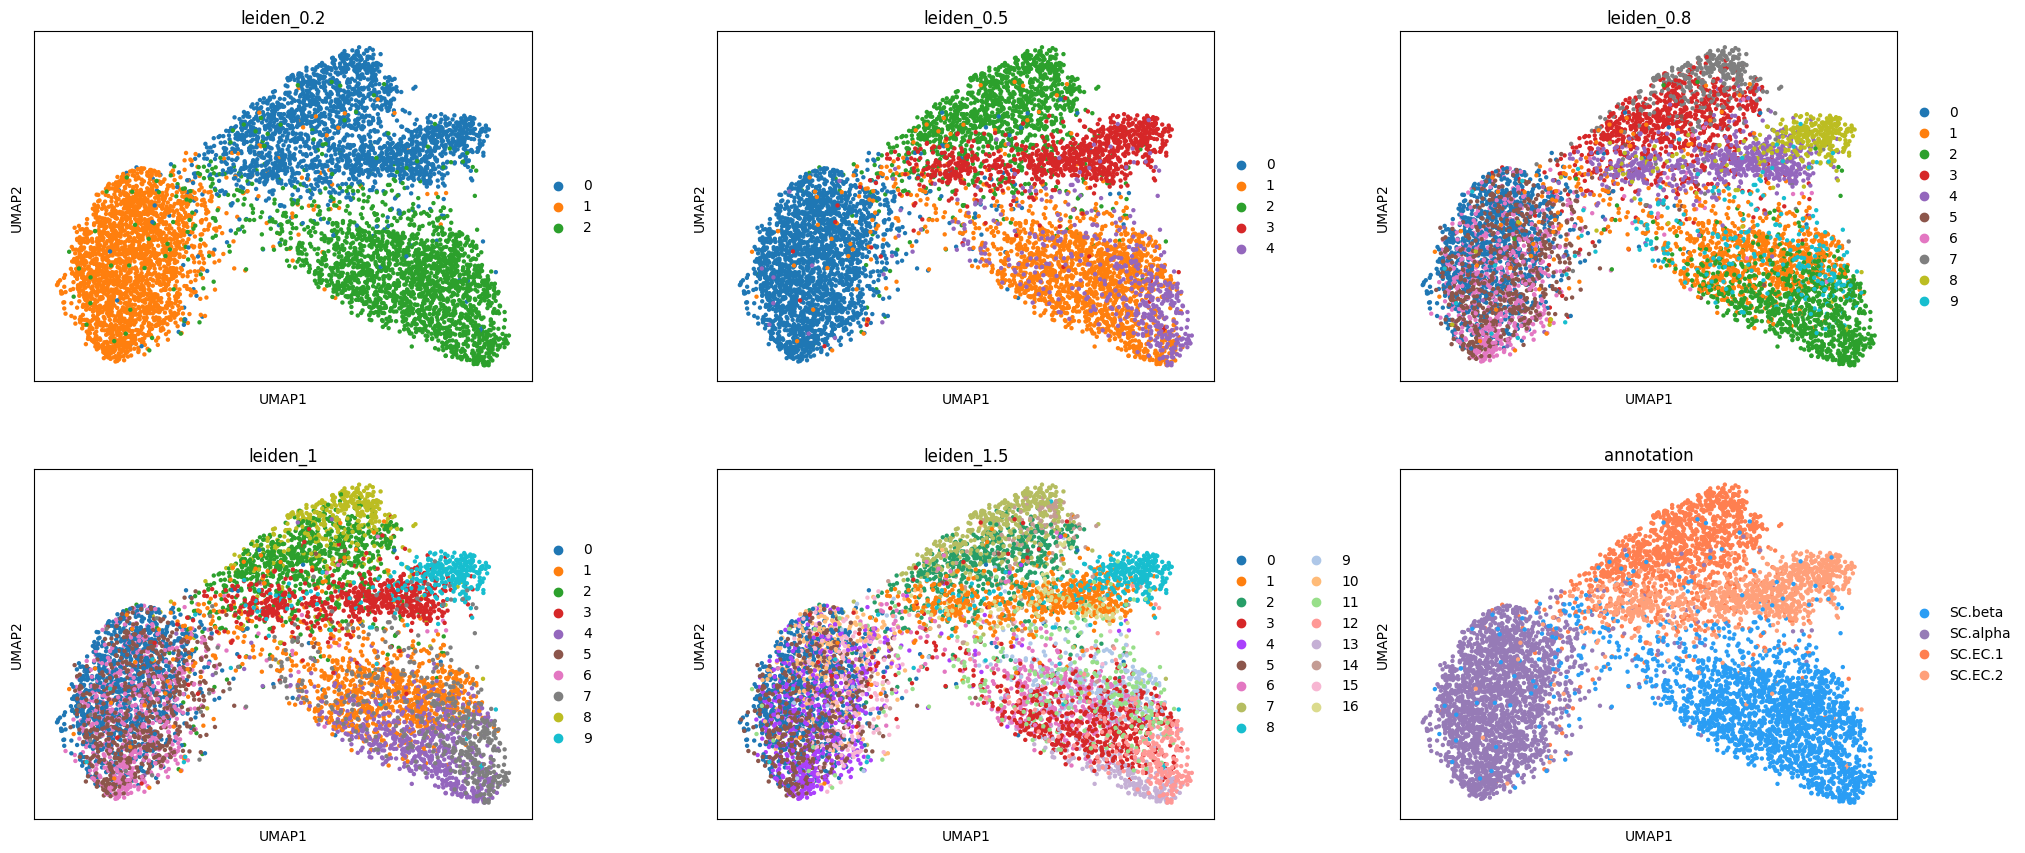

In [ ]:
# Check different clustering res
sc.pl.umap(adata_topics, color=["leiden_0.2", "leiden_0.5", "leiden_0.8", "leiden_1", "leiden_1.5", "annotation"], ncols=3, s=40, wspace=0.25, show=False)

Text(0.5, 1.0, 'Annotation proportions in leiden_0.5 clusters')

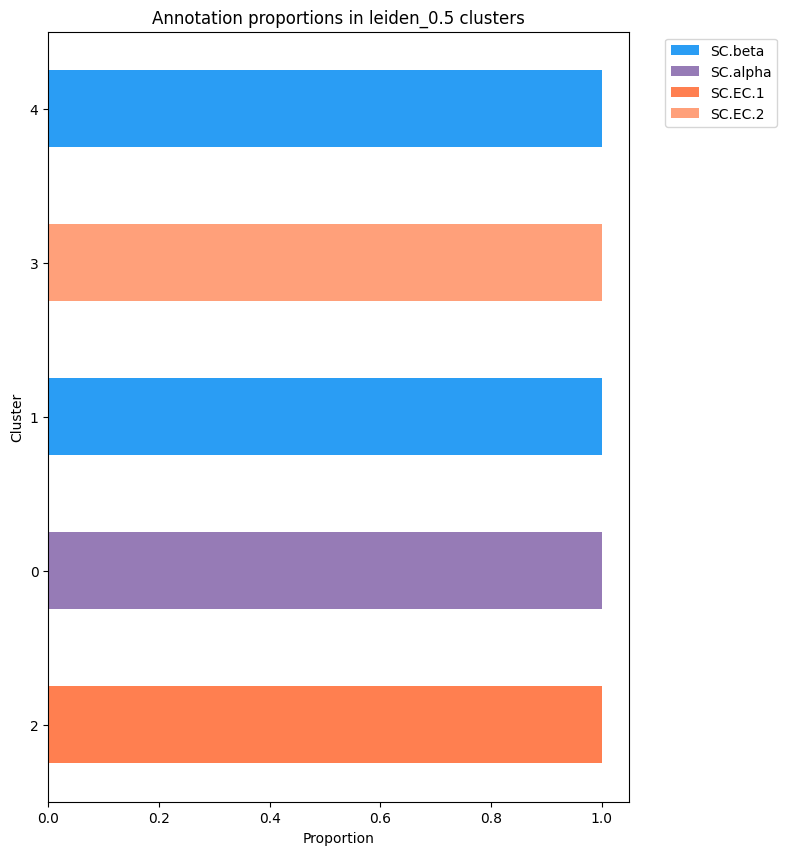

In [ ]:
# Stacked barplot of annotation proportions in leiden_0.5 clusters
leiden = adata_topics.obs["leiden_0.5"].unique().tolist()
annotation_proportions = []
for cluster in leiden:
    proportions = adata_topics.obs[adata_topics.obs["leiden_0.5"] == cluster]["annotation"].value_counts(normalize=True)
    proportions.name = cluster
    annotation_proportions.append(proportions)
annotation_proportions = pd.concat(annotation_proportions, axis=1).T
annotation_proportions = annotation_proportions[cellid_colors.keys()]

# Plot horizontal barplot, legend outside to right
fig, ax = plt.subplots(figsize=(7.5, 10))
annotation_proportions.plot.barh(stacked=True, ax=ax, color=cellid_colors.values())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Proportion")
plt.ylabel("Cluster")
plt.title("Annotation proportions in leiden_0.5 clusters")

/cellar/users/aklie/opt/miniconda3/envs/test_scenicplus/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 41.972222222222314, 'Topic')

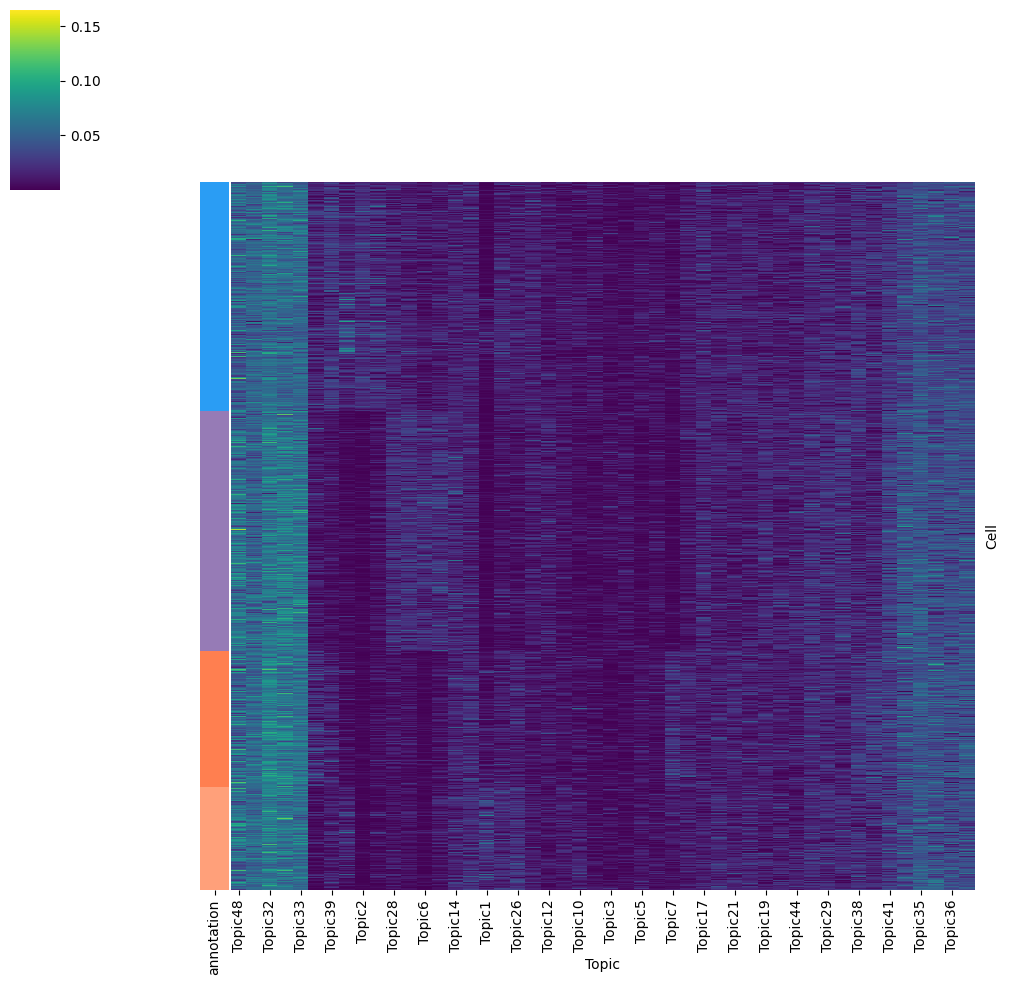

In [ ]:
# Clustermap of topics
labels = adata_topics.obs["annotation"]
row_colors = labels.map(cellid_colors)
row_colors.index = adata_topics.obs_names

# Sort the rows by annotation
cell_ordering = adata.obs.sort_values("annotation").index
df = adata_topics.to_df()
df = df.loc[cell_ordering]

ax = sns.clustermap(
    df,
    row_cluster=False,
    col_cluster=True,
    yticklabels=False,
    cmap="viridis",
    row_colors=row_colors,
)

# Add row colors from adata.obs["annotation"]
ax.ax_row_dendrogram.set_visible(False)

ax.ax_col_dendrogram.set_visible(False)
ax.ax_heatmap.set_ylabel("Cell")
ax.ax_heatmap.set_xlabel("Topic")


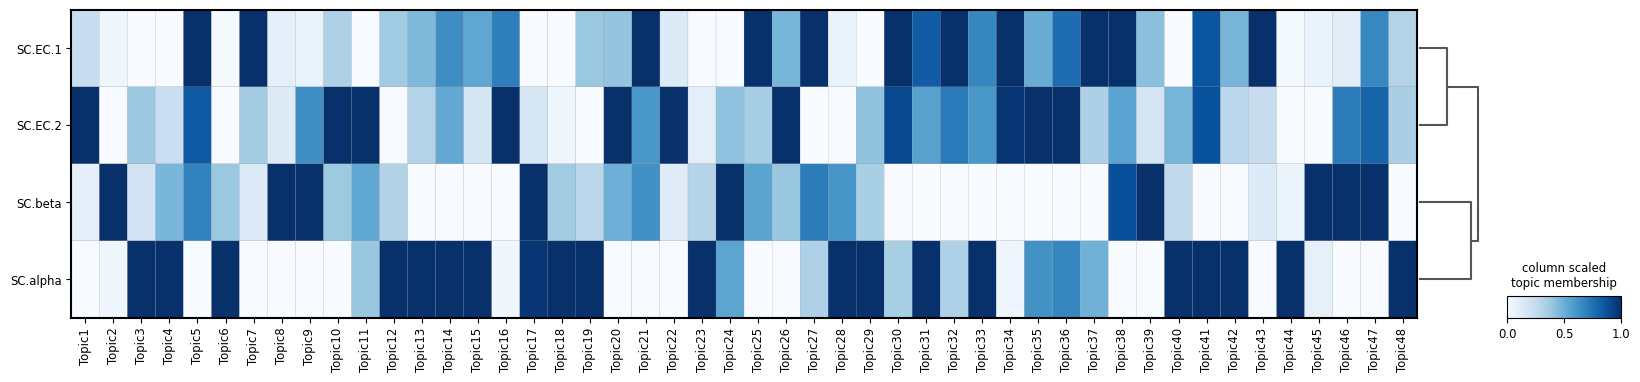

In [ ]:
sc.pl.matrixplot(
    adata_topics,
    var_names=adata_topics.var_names,
    groupby="annotation",
    dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\ntopic membership",
    figsize=(20, 4),
)

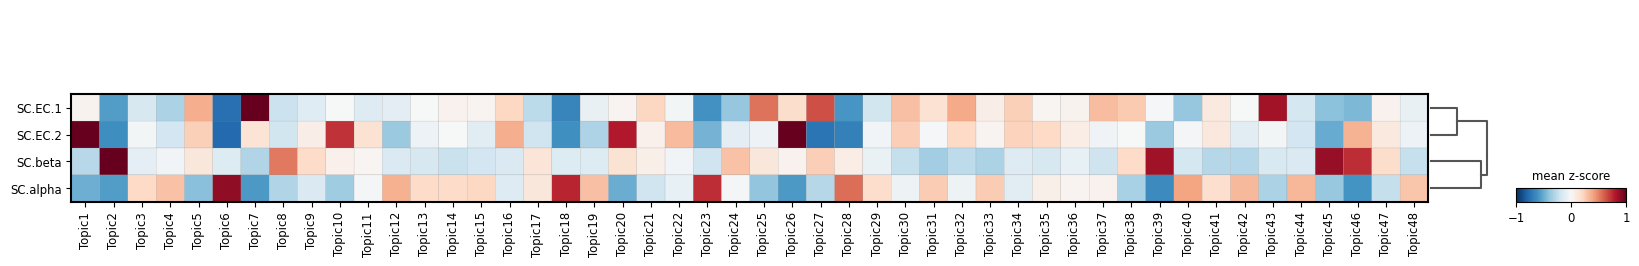

In [ ]:
sc.pl.matrixplot(
    adata_topics,
    var_names=adata_topics.var_names,
    groupby="annotation",
    dendrogram=True,
    colorbar_title="mean z-score",
    layer="scaled",
    vmin=-1,
    vmax=1,
    cmap="RdBu_r",
)